In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from dataset import SyntheticRankingBanditDataset
from ope.estimator import InversePropensityScore as IPS
from ope.meta import RankingOffPolicyEvaluation
from utils.util import aggregate_simulation_results, visualize_mean_squared_error
from utils.policy import gen_eps_greedy

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# setting 1

# 変数
val_sizes=[1000, 2000, 3000, 4000, 5000]

# 定数
behavior_params = {"cascade": 1.0}
test_size=100000
n_sim=1000
dim_context=5
n_actions_at_k=2
len_list=6
beta=-1
eps=0.3
random_state=12345
interaction_noise=2
ope_estimators=[IPS(estimator_name="SIPS"), IPS(estimator_name="IIPS"), IPS(estimator_name="RIPS")]

In [7]:
# experiment-1 varying data size under cascade user behavior

dataset = SyntheticRankingBanditDataset(
    n_actions_at_k=n_actions_at_k,
    len_list=len_list,
    dim_context=dim_context,
    behavior_params=behavior_params,
    beta=beta,
    eps=eps,
    random_state=random_state,
    interaction_noise=interaction_noise
)
# calculate ground truth policy value

test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, is_online=True)
policy_value = test_data["expected_reward_factual"].sum(1).mean()

result_df_list = []
for val_size in val_sizes:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        action_dist = gen_eps_greedy(expected_reward=val_data["evaluation_policy_logit"], eps=eps)
        
        # off policy evaluation
        ope = RankingOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000...: 100% 1000/1000 [00:03<00:00, 287.12it/s]
val_size=2000...: 100% 1000/1000 [00:12<00:00, 80.52it/s]
val_size=3000...: 100% 1000/1000 [00:18<00:00, 55.50it/s]
val_size=4000...: 100% 1000/1000 [00:22<00:00, 43.68it/s]
val_size=5000...: 100% 1000/1000 [00:28<00:00, 34.51it/s]


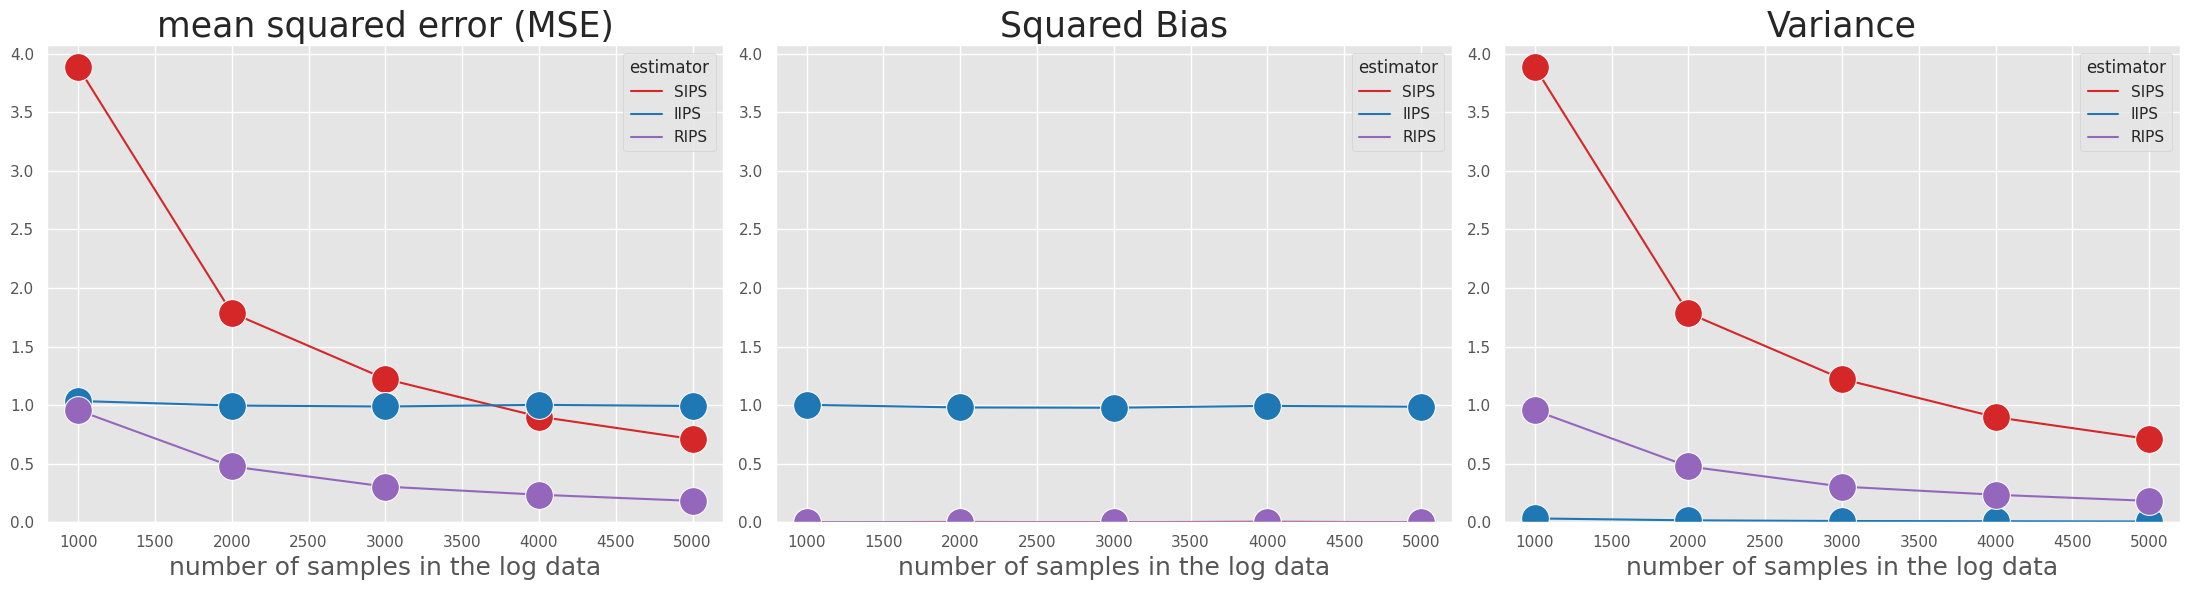

In [8]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of samples in the log data")

In [9]:
# setting 2

# 変数
len_list_list=[2, 4, 6, 8, 10, 12]

# 定数
behavior_ratio = {"cascade": 1.0}
test_size=100000
n_sim=1000
dim_context=3
n_actions_at_k=2
val_size=2000
beta=-1
eps=0.3
random_state=12345
interaction_noise=2
ope_estimators=[IPS(estimator_name="SIPS"), IPS(estimator_name="IIPS"), IPS(estimator_name="RIPS")] 

In [10]:
# experiment-2 varying len_list under independent user behavior

result_df_list = []
for len_list in len_list_list:
    
    dataset = SyntheticRankingBanditDataset(
        n_actions_at_k=n_actions_at_k,
        len_list=len_list,
        dim_context=dim_context,
        behavior_params=behavior_params,
        beta=beta,
        eps=eps,
        random_state=random_state,
        interaction_noise=interaction_noise
    )
    # calculate ground truth policy value

    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, is_online=True)
    policy_value = test_data["expected_reward_factual"].sum(1).mean()
    
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"len_list={len_list}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        action_dist = gen_eps_greedy(expected_reward=val_data["evaluation_policy_logit"], eps=eps)
        
        # off policy evaluation
        ope = RankingOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=len_list
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

len_list=2...: 100% 1000/1000 [00:03<00:00, 299.60it/s]
len_list=4...: 100% 1000/1000 [00:04<00:00, 213.76it/s]
len_list=6...: 100% 1000/1000 [00:11<00:00, 85.55it/s]
len_list=8...: 100% 1000/1000 [00:13<00:00, 72.61it/s]
len_list=10...: 100% 1000/1000 [00:17<00:00, 57.88it/s]
len_list=12...: 100% 1000/1000 [00:19<00:00, 51.67it/s]


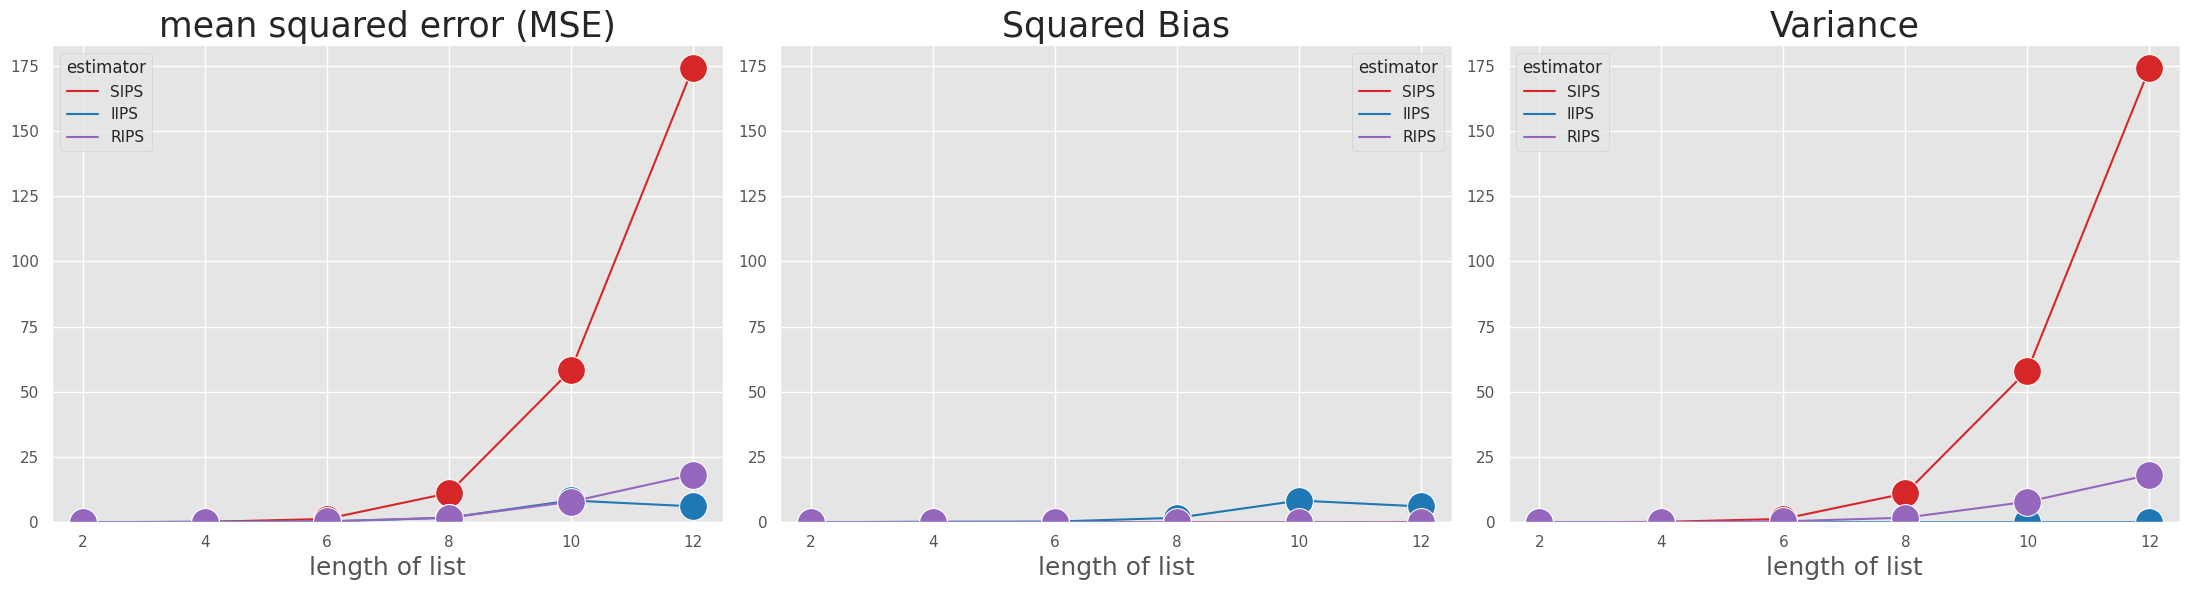

In [11]:
visualize_mean_squared_error(result_df=result_df, xlabel="length of list")